In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework2

Mounted at /gdrive
/gdrive/My Drive/Homework2


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [4]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [5]:
dataset = np.load('training_data.npy')
periods = np.load('valid_periods.npy')
cat = np.load('categories.npy')
print(dataset.shape)
print(periods.shape)
print(cat.shape)

(48000, 2776)
(48000, 2)
(48000,)


In [6]:
# building individual sequences
X = []
window = 80
stride = 30
for i in range(dataset.shape[0]):
  j = periods[i,0]
  while(j+window < periods[i,1]):
    X.append(dataset[i,j:j+window])
    j = j+stride

In [7]:
X = np.array(X)

In [66]:
idx = 3450
if idx >= X.shape[0]:
  idx = X.shape[0]

In [67]:
def inspect_sequences(a,b):
    plt.plot(np.arange(window), a[:], color='blue')
    plt.plot(np.arange(window), b[:], color='orange')
    plt.ylim(0,1)
    plt.show()

## Uniform noise addition

In [71]:
def add_noise(sequence,alpha):
  new_sequence = np.zeros(sequence.shape)
  for i in range(len(sequence)):
    new_sequence[i] = sequence[i] + alpha*random.random()/100
  return new_sequence

In [72]:
alpha = 10    # percentage relative error
y = add_noise(X[idx],alpha)

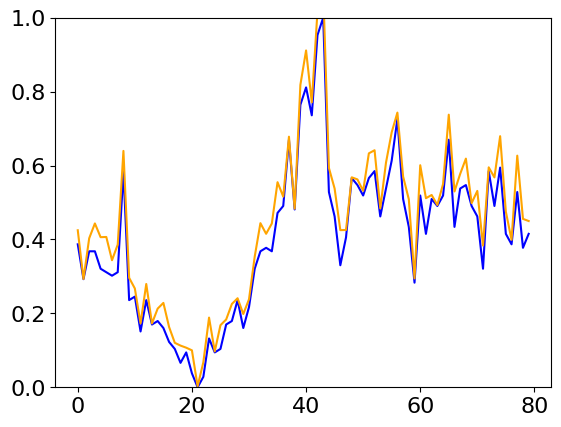

In [73]:
inspect_sequences(X[idx], y)

## FFT filtering

In [74]:
def FFT_filter(sequence,num_modes):
  if num_modes > len(sequence):
    num_modes = len(sequence)
  mask = np.ones(num_modes)
  mask = np.append(mask,np.zeros(len(sequence)-num_modes))
  a = np.fft.fft(sequence)
  new_sequence = np.fft.ifft(np.multiply(a,mask))
  return new_sequence

In [75]:
modes = 35
y = FFT_filter(X[idx],modes)

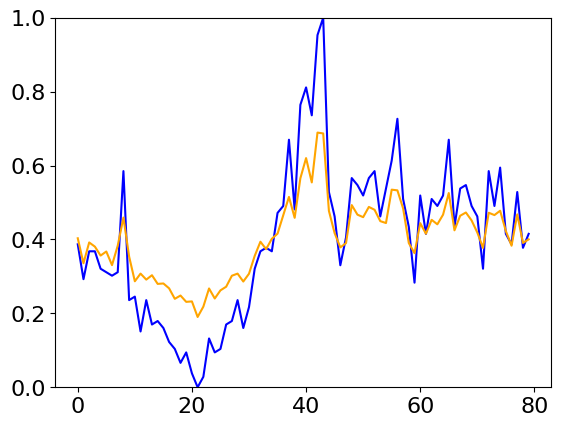

In [76]:
inspect_sequences(X[idx], y)

## Savitzky-Golay filtering

In [77]:
import scipy

In [78]:
wnd = 5
order = 2    # needs to be smaller than wnd
y = scipy.signal.savgol_filter(X[idx],wnd,order)

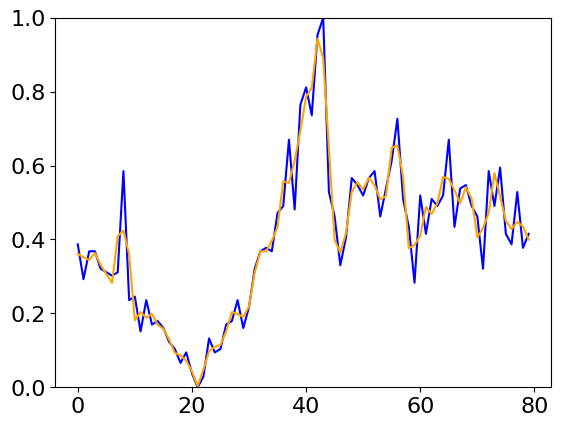

In [79]:
inspect_sequences(X[idx], y)

## Autocorrelation function

Text(0.5, 1.0, 'Autocorrelation')

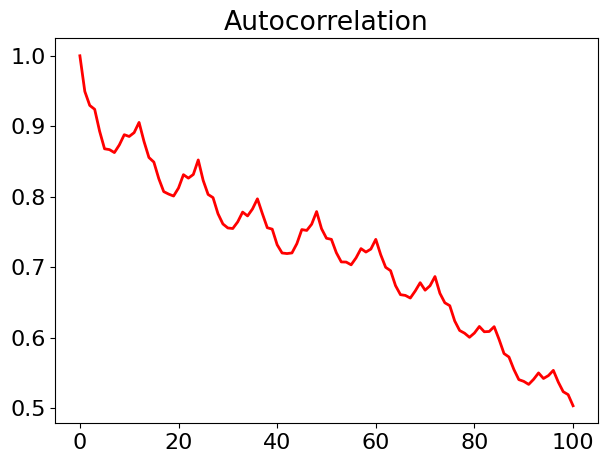

In [81]:
from statsmodels.tsa import stattools

idx_dataset = 24    # here we need to consider the whole time series, so we take the data from dataset and not from X

acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(dataset[idx_dataset],nlags=100,qstat=True,fft=True,alpha = 0.05)

plt.figure(figsize=(7, 5))
plt.plot(pd.Series(acf_djia), color='r', linewidth=2)
plt.title('Autocorrelation')